<a href="https://colab.research.google.com/github/Cehiim/TeoriaDosGrafos/blob/main/Projeto/grafos_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informações gerais

## Integrantes
* Cesar Hideki Imai - 10402758
* João Victor Dallapé Madeira - 10400725
* David Varão Lima Bentes Pessoa - 10402647

# Setup

## Integração dos pacotes

O pacote `vectordb2` é usado para armazenar e recuperar textos usando técnicas de *chunking* (segmentação de texto), *embedding* (conversão de texto para vetores numéricos) e busca vetorial.

In [135]:
%pip install vectordb2

O pacote requests pode ser usado para recuperar o arquivo por meio de requisição em HTTP (esse pacote é opcional).

In [136]:
%pip install requests

O pacote `network pyvis` é usado para criar uma visualização interativa de grafos.

In [137]:
%pip install networkx pyvis

Importação das bibliotecas

In [138]:
from vectordb import Memory
import requests
from pyvis.network import Network
import matplotlib.pyplot as plt # Será usado para apresentação visual do grafo
import os # Será usado métodos para limpar o terminal para atualizar a interface em cada iteração do sistema
import time # Será usado método de espera para atualizar a interface gradualmente

## Classe Grafo

In [139]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 13 13:59:10 2023

@author: icalc
"""
class Grafo:
    TAM_MAX_DEFAULT = 100 # qtde de vértices máxima default
    # construtor da classe grafo
    def __init__(self, n=TAM_MAX_DEFAULT):
        self.n = n # número de vértices
        self.m = 0 # número de arestas
        # matriz de adjacência
        self.adj = [[0 for i in range(n)] for j in range(n)]

	# Insere uma aresta no Grafo tal que
	# v é adjacente a w
    def insereA(self, v, w):
        if self.adj[v][w] == 0:
            self.adj[v][w] = 1
            self.m+=1 # atualiza qtd arestas

# remove uma aresta v->w do Grafo
    def removeA(self, v, w):
        if(v == w):
            return
        # testa se temos a aresta
        if self.adj[v][w] == 1:
            self.adj[v][w] = 0
            self.m -= 1  # atualiza qtd arestas

	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    def show(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                if self.adj[i][w] == 1:
                    print(f"Adj[{i:2d},{w:2d}] = 1 ", end="")
                else:
                    print(f"Adj[{i:2d},{w:2d}] = 0 ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )


	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    # Apresentando apenas os valores 0 ou 1
    def showMin(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                if self.adj[i][w] == 1:
                    print(" 1 ", end="")
                else:
                    print(" 0 ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )

## Classe GrafoR (Grafo direcionado rotulado)

In [185]:
# Grafo como uma matriz de adjacência rotulado
class GrafoR(Grafo):
# Não bota o init, vai bugar a classe

    def insereA(self, v, w, p):
        if self.adj[v][w] == 0:
            self.adj[v][w] = p
            self.m += 1  # atualiza qtd arestas

    def removeA(self, v, w):
        if(v == w):
            return
        # testa se temos a aresta
        if self.adj[v][w] != 0:
            self.adj[v][w] = 0
            self.m -= 1  # atualiza qtd arestas

    def show(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                print(f"Adj[{i:2d},{w:2d}] = {self.adj[i][w]:.2f} ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )

	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    # Apresentando apenas os valores 0 ou 1
    def showMin(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                print(f" {self.adj[i][w]:.2f} ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )

    def insereV(self):
        for i in range(self.n):
            self.adj[i].append(0)
        self.n += 1
        self.adj.append([0]*self.n)

    def removeV(self, vertice):
        if(vertice >= self.n or vertice < 0):
            return False
        for i in range(self.n):
            if(i == vertice):
                for j in range(self.n):
                    self.removeA(vertice, j) # Exclui arestas fantasmas
            self.removeA(i,vertice)
            if(i >= vertice and i != self.n-1): # Substitui as conexões do vértice a ser retirado e
                              # os vértices posteriores a ele com as conexões do próximo vértice
                self.adj[i] = self.adj[i+1]
            self.adj[i].pop(vertice) # Remove o vértice escolhido da linha da matriz
        self.adj.pop() # Remove a última linha da matriz
        self.n -= 1
        return True

'''
    def dfs_edges(self):
        visitados = [False] * len(self.vertices)
        edges = []

        def dfs(v):
            visitados[v] = True
            for i in range(len(self.vertices)):
                if self.matriz_adj[v][i] == 1 and not visitados[i]:
                    edges.append((v, i))
                    dfs(i)

        for nodo in range(len(self.vertices)):
            if not visitados[nodo]:
                dfs(nodo)

        return edges

    def tem_ciclo(self):
        visitados = [False] * len(self.vertices)
        rec_stack = [False] * len(self.vertices)

    def classificar_complexidade(grafo):
        if grafo.number_of_nodes() == 0:
            return 'C0'  # Grafo vazio

        if grafo.number_of_edges() == 0:
            return 'C1'  # Grafo com um único vértice ou sem arestas

        if grafo.tem_ciclo():
            return 'C3'  # Grafo tem ciclos

        if len(grafo.dfs_edges()) > 0:
            return 'C2'  # Grafo não tem ciclos, mas tem caminhos com mais de um vértice

        return 'C1'  # Grafo sem ciclos, todos os caminhos com exatamente um vértice

    def cfc(self):
        stack = []
        visitados = [False] * len(self.vertices)

        # Passo 1: Preencher a pilha com base na ordem de finalização do DFS
        for i in range(len(self.vertices)):
            if not visitados[i]:
                self.dfs_util(i, visitados, stack)

        # Passo 2: Criar o grafo transposto
        g_transposto = self.transpose()

        # Passo 3: Fazer DFS no grafo transposto de acordo com a pilha
        visitados = [False] * len(self.vertices)
        componentes = []

        while stack:
            v = stack.pop()
            if not visitados[v]:
                componente = []
                g_transposto.dfs_explorar(v, visitados, componente)
                componentes.append(componente)

        return componentes

    def grafo_reduzido(grafo):
        componentes = grafo.cfc()
        mapeamento = {}
        for i, componente in enumerate(componentes):
            for v in componente:
                mapeamento[v] = i

        matriz_reduzida = [[0 for _ in range(len(componentes))] for _ in range(len(componentes))]

        for u, v in grafo.arestas:
            if mapeamento[u] != mapeamento[v]:
                matriz_reduzida[mapeamento[u]][mapeamento[v]] = 1

        return matriz_reduzida
'''

"\n    def dfs_edges(self):\n        visitados = [False] * len(self.vertices)\n        edges = []\n\n        def dfs(v):\n            visitados[v] = True\n            for i in range(len(self.vertices)):\n                if self.matriz_adj[v][i] == 1 and not visitados[i]:\n                    edges.append((v, i))\n                    dfs(i)\n\n        for nodo in range(len(self.vertices)):\n            if not visitados[nodo]:\n                dfs(nodo)\n\n        return edges\n\n    def tem_ciclo(self):\n        visitados = [False] * len(self.vertices)\n        rec_stack = [False] * len(self.vertices)\n\n    def classificar_complexidade(grafo):\n        if grafo.number_of_nodes() == 0:\n            return 'C0'  # Grafo vazio\n\n        if grafo.number_of_edges() == 0:\n            return 'C1'  # Grafo com um único vértice ou sem arestas\n\n        if grafo.tem_ciclo():\n            return 'C3'  # Grafo tem ciclos\n\n        if len(grafo.dfs_edges()) > 0:\n            return 'C2'  # Graf

## Classe Memory

Aqui é utilizado a biblioteca VectorDB para criar uma memória virtual.

```
memoria = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0})
```

- `chunking_strategy` define a estratégia de fragmentação dos dados. No modo "sliding_window", os dados são divididos em *chunks* (pedaços de texto) de tamanho fixo.

- `window_size` define a quantidade de palavras que um *chunk* representa. Neste caso, cada *chunk* representa uma palavra.

- `overlap` define quantos elementos de sobreposição existirão entre os *chunks* adjacentes. Neste caso, não haverá sobreposição já que as palavras usadas não formam frases, logo são independentes uma das outras.

### Método SAVE

O método é usado para fazer o *embedding* de uma palavra e inserir na memória.
```
memoria.save("palavra")
```
* `palavra` é a *string* da palavra desejada para inserir na memória.

### Método SEARCH

O método é usado para fazer o *embedding* de uma palavra para consultar a proximidade com as palavras salvas na memória através da busca vetorial.
```
busca = memoria.search(palavra, top_n=4)
```
* `palavra` é a string da palavra usada para consultar a proximidade com as palavras salvas na memória.
* `top_n` define o número de palavras retornadas da consulta.


### [Referência](https://vectordb.com/)

## Classe Network

Aqui é utilizado a biblioteca Pyvis para criar uma instância para visualizar redes/grafos de forma interativa.

```
net = Network(notebook=True, cdn_resources='remote', directed=True)
```
* `notebook=True`: Esta opção indica que a visualização da rede será exibida diretamente em um notebook Jupyter.

* `cdn_resources='remote'`: Esta opção especifica que os recursos necessários (como bibliotecas JavaScript e CSS) serão carregados de um Content Delivery Network (CDN) remoto. Isso pode ajudar a reduzir o tempo de carregamento e garantir que você esteja usando as versões mais recentes desses recursos.

* `directed=True`: Especifica para que o grafo seja direcionado.

### [Referência](https://pyvis.readthedocs.io/en/latest/documentation.html)

## Funções auxiliares

### Cria vértice

In [219]:
def criaVertice(palavra, indice):
  vertice = {
      "palavra": palavra, # Recupera cada palavra e tira o "\n"
      "indice": indice,
      "n_vizinhos": 0,
      "proximos": []
  }
  return vertice

### Lê arquivo

Os dados do documento são importados e guardados na variável `dados`.

In [220]:
def leArquivoHTTP(url):
  arquivo = requests.get(url).text

  lista = arquivo.split() # Distribui cada elemento do arquivo numa lista
  n_palavras = int(lista.pop(0)) # Separa o número de palavras (primeira linha do arquivo)
  vertices = []
  for i in range(n_palavras):
    vertice = criaVertice(lista[i], i)
    vertices.append(vertice)

  dados = [n_palavras]
  dados.append(vertices)

  return dados

In [221]:
def leArquivo(origem):
  try:
    with open(origem, 'r', encoding='utf-8') as arquivo:
      n_palavras = int(arquivo.readline()) # Recupera o número de palavras (primeira linha do arquivo)

      vertices = []
      for i in range(n_palavras):
        vertice = criaVertice(arquivo.readline().strip(), i)
        vertices.append(vertice)

    dados = [n_palavras]
    dados.append(vertices)

    return dados

  except FileNotFoundError:
      print("[Erro: Arquivo não encontrado]")

### Embedding

Cada palavra é convertida para um vetor numérico e guardada na memória.

In [222]:
def embedding(memoria, n_palavras, vertices): # Método para fazer o embedding e inserção na memória de todas as palavras
  for i in range(n_palavras):
    memoria.save(vertices[i]["palavra"])

### Busca vetorial

Quanto menor é a distância, maior é a proximidade semântica.

In [223]:
def buscaVetorial(memoria, palavra): # Método para retornar os quatro elementos com maior proximidade semântica de uma palavra
  busca = memoria.search(palavra, top_n=4)
  return busca

### Busca índice

Busca um índice através da palavra dentro da lista de vértices.

In [224]:
def buscaIndice(n_palavras, vertices, palavra):
  for i in range(n_palavras):
    if(vertices[i]["palavra"] == palavra):
      return vertices[i]["indice"]
  return -1

### Busca palavra

Busca uma palavra através do índice dentro da lista de vértices.

In [225]:
def buscaPalavra(n_palavras, vertices, indice):
  if(indice >= n_palavras or indice < 0):
    return "[Erro: índice inválido]"
  for i in range(n_palavras):
    if(vertices[i]["indice"] == indice):
      return vertices[i]["palavra"]
  return "[Erro: índice não encontrado]"

### Cria vizinho

In [226]:
def criaVizinho(palavra, indice, distancia):
  proximo = {
      "vizinho": palavra,
      "indice": indice,
      "distancia": distancia
  }
  return proximo

### Integra grafo

A palavra mais próxima armazenada na memória é ela mesma, portanto para encontrar as outras três palavras mais próximas foram recuperadas as palavras de índice 1 até 4.

In [227]:
def integraGrafo(memoria, n_palavras, vertices):
  grafo = GrafoR(n_palavras) # Cria um grafo rotulado
  for i in range(n_palavras):
    busca = buscaVetorial(memoria, vertices[i]["palavra"])
    proximos = []
    for j in range(1,4):
      palavra = busca[j]['chunk']
      distancia = busca[j]['distance']
      proximo = criaVizinho(palavra, buscaIndice(n_palavras, vertices, palavra), distancia)
      proximos.append(proximo)
      vertices[i]["n_vizinhos"] += 1
      grafo.insereA(vertices[i]["indice"], proximo["indice"], proximo["distancia"])
    vertices[i]["proximos"] = proximos
  return grafo

### Grava dados

In [228]:
def gravaDados(n_palavras, vertices):
  with open("grafo.txt", "w") as arquivo:
    for i in range(n_palavras):
      palavra = vertices[i]["palavra"]
      arquivo.write(palavra+"\n")

### Insere vértice

In [229]:
def insereVertice(grafo, n_palavras, vertices, palavra):
  if(buscaIndice(n_palavras, vertices, palavra) == -1):
    grafo.insereV()
    vertices.append(criaVertice(palavra, n_palavras))
  else:
    print("[Erro: Palavra já existe]")

### Cria aresta

In [230]:
def criaAresta(origem, destino):
  aresta = [0] * 2
  aresta[0] = origem
  aresta[1] = destino
  return aresta

### Busca vizinho

In [231]:
def buscaVizinho(n_vizinhos, vizinhos, indice):
  for i in range(n_vizinhos):
    if(vizinhos[i]["indice"] == indice):
      return i
  return -1

### Insere aresta

In [232]:
def insereAresta(grafo, n_palavras, vertices, aresta, peso):
  origem = aresta[0]
  destino = aresta[1]
  if(origem >= n_palavras or origem < 0):
    print("[Erro: origem não existe]")

  elif(destino >= n_palavras or destino < 0):
    print("[Erro: destino não existe]")

  else:
    n_vizinhos = vertices[origem]["n_vizinhos"]
    vizinhos = vertices[origem]["proximos"]

    if(buscaVizinho(n_vizinhos, vizinhos, destino) != -1):
      print("[Erro: aresta já existe]")

    else:
      grafo.insereA(origem, destino, peso)
      palavra_destino = buscaPalavra(n_palavras, vertices, destino)
      vertices[origem]["proximos"].append(criaVizinho(palavra_destino, destino, peso))
      vertices[origem]["n_vizinhos"] += 1

### Remove vértice

In [233]:
def removeVertice(grafo, n_palavras, vertices, removido):
  if(removido >= n_palavras or removido < 0):
    print("[Erro: vértice não existe]")
  else:
    grafo.removeV(removido)
    for i in range(n_palavras - 1):
      if(i >= removido):
        vertices[i] = vertices[i+1]
        vertices[i]["indice"] = i

      n_vizinhos = vertices[i]["n_vizinhos"]
      vizinhos = vertices[i]["proximos"]
      posicao = buscaVizinho(n_vizinhos, vizinhos, removido)

      if(posicao != -1):
        aresta = criaAresta(vertices[i]["indice"], removido)
        removeAresta(grafo, n_palavras, vertices, aresta)

    vertices.pop()

### Remove aresta

In [234]:
def removeAresta(grafo, n_palavras, vertices, aresta):
  origem = aresta[0]
  destino = aresta[1]
  if(origem >= n_palavras or origem < 0):
    print("[Erro: origem não existe]")

  elif(destino >= n_palavras or destino < 0):
    print("[Erro: destino não existe]")

  else:
    n_vizinhos = vertices[origem]["n_vizinhos"]
    vizinhos = vertices[origem]["proximos"]
    posicao = buscaVizinho(n_vizinhos, vizinhos, destino)
    if(posicao == -1):
      print("[Erro: aresta não existe]")

    else:
      grafo.removeA(origem, destino)
      vertices[origem]["proximos"].pop(posicao)
      vertices[origem]["n_vizinhos"] -= 1

### Imprime vértices

In [235]:
def imprimeVertices(network, n_palavras, vertices):
  for i in range(n_palavras):
    network.add_node( # Adiciona vértices
        i, # Índice
        label=vertices[i]["palavra"], # Descrição do vértice
        color="yellow"
    )

### Imprime arestas

In [236]:
def imprimeArestas(network, n_palavras, vertices):
  for i in range(n_palavras):
    vizinhos = vertices[i]["proximos"]
    for j in range(vertices[i]["n_vizinhos"]):
      distancia = float(vizinhos[j]["distancia"])
      if(distancia >= 0 and distancia <= 1):
        peso = (1-distancia) # Caso seja um valor entre a escala da distância semântica
      else:
        peso = distancia # Caso seja um valor fora do limite
      network.add_edge( # Adiciona as arestas
          vertices[i]["indice"], # Origem
          vizinhos[j]["indice"], # Destino
          value=peso, # Peso
          title=f'''
          Origem: {vertices[i]["palavra"]}
          Destino: {vizinhos[j]["vizinho"]}
          Peso: {peso:.2f}
                        ''', # Descrição
          color="red"
      )

### Imprime grafo

In [237]:
def imprimeGrafo(n_palavras, vertices):
  net = Network(notebook=True, cdn_resources='remote', directed=True, height="1200px", width="100%", bgcolor="black", font_color="white")
  imprimeVertices(net, n_palavras, vertices)
  imprimeArestas(net, n_palavras, vertices)
  net.barnes_hut() # Dispersa melhor os vértices
  net.show("grafo.html") # Salva o grafo

### Mostra vértice

In [265]:
def mostraVertice(vertices, indice):
  palavra = vertices[indice]["palavra"]
  n_vizinhos = vertices[indice]["n_vizinhos"]
  vizinhos = vertices[indice]["proximos"]
  print(f"\nPalavra: {palavra}\n")
  for i in range(n_vizinhos):
    vizinho =  vizinhos[i]["vizinho"]
    distancia = vizinhos[i]["distancia"]
    print(f'''
    Vizinho: {vizinho}
    Distância: {distancia}''')

# Testes

## 1. Ler dados (Feito)

In [238]:
d = leArquivoHTTP('https://raw.githubusercontent.com/Cehiim/TeoriaDosGrafos/refs/heads/main/Projeto/teste.txt')
#d = leArquivo("palavras.txt")
print(d)

[8, [{'palavra': 'Ecossistema', 'indice': 0, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Sustentabilidade', 'indice': 1, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Biodiversidade', 'indice': 2, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Reciclagem', 'indice': 3, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Conservação', 'indice': 4, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Poluição', 'indice': 5, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Desmatamento', 'indice': 6, 'n_vizinhos': 0, 'proximos': []}, {'palavra': 'Reflorestamento', 'indice': 7, 'n_vizinhos': 0, 'proximos': []}]]


A palavra mais próxima armazenada na memória é ela mesma, portanto para encontrar as outras três palavras mais próximas foram recuperadas as palavras de índice 1 até 4.

In [239]:
m = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0}) # Memória
n = d[0] # Número de palavras
v = d[1] # Lista de vértices (cada vértice é organizado em palavra, índice e vizinhos próximos)

embedding(m, n, v)

b = buscaVetorial(m, "Biodiversidade")
print(b)
print(f"\n\nBusca: Biodiversidade\n")
for i in range(1,4):
  palavra = b[i]['chunk']
  distancia = b[i]['distance']
  print(f"Palavra: {palavra}\nDistância: {distancia:.2f}\n")

Initiliazing embeddings:  normal
OK.
[{'chunk': 'Biodiversidade', 'metadata': {}, 'distance': 0.0}, {'chunk': 'Sustentabilidade', 'metadata': {}, 'distance': 0.44970125}, {'chunk': 'Ecossistema', 'metadata': {}, 'distance': 0.5811522}, {'chunk': 'Poluição', 'metadata': {}, 'distance': 0.6769276}]


Busca: Biodiversidade

Palavra: Sustentabilidade
Distância: 0.45

Palavra: Ecossistema
Distância: 0.58

Palavra: Poluição
Distância: 0.68



In [240]:
g = integraGrafo(m, n, v)
print(v[0]) # Informações do primeiro elemento da lista de vértices
g.showMin()

{'palavra': 'Ecossistema', 'indice': 0, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.5811522}, {'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.7258596}]}

 n:  8 m: 24

 0.00  0.59  0.58  0.00  0.00  0.00  0.00  0.73 

 0.59  0.00  0.45  0.00  0.00  0.00  0.00  0.69 

 0.58  0.45  0.00  0.00  0.00  0.68  0.00  0.00 

 0.80  0.00  0.00  0.00  0.00  0.78  0.00  0.64 

 0.00  0.78  0.00  0.00  0.00  0.78  0.86  0.00 

 0.00  0.00  0.68  0.00  0.00  0.00  0.72  0.65 

 0.00  0.00  0.79  0.00  0.00  0.72  0.00  0.69 

 0.00  0.00  0.00  0.64  0.00  0.65  0.69  0.00 


fim da impressao do grafo.


## 2. Gravar dados (Feito)

In [241]:
gravaDados(n,v)

No Google Colab o arquivo nomeado como `grafo.txt` poderá ser acessado nos arquivos localizado no canto esquerdo.

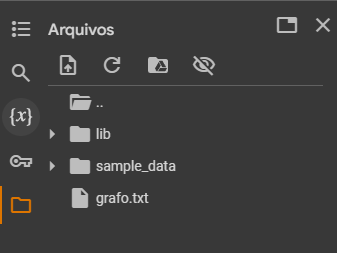

## 3. Inserir vértice (Feito)

In [242]:
insereVertice(g, n, v, "Maritaca")
n += 1
print(n)
print(v)
g.showMin()

9
[{'palavra': 'Ecossistema', 'indice': 0, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.5811522}, {'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.7258596}]}, {'palavra': 'Sustentabilidade', 'indice': 1, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.44970125}, {'vizinho': 'Ecossistema', 'indice': 0, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.692708}]}, {'palavra': 'Biodiversidade', 'indice': 2, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.44970125}, {'vizinho': 'Ecossistema', 'indice': 0, 'distancia': 0.5811522}, {'vizinho': 'Poluição', 'indice': 5, 'distancia': 0.6769276}]}, {'palavra': 'Reciclagem', 'indice': 3, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.63607174}, {'vizinho': 'Poluição', '

## 4. Inserir aresta (Feito)

In [243]:
a = criaAresta(8, 4)
a2 = criaAresta(8, 0)
insereAresta(g, n, v, a, 0.8)
print(v[8])
insereAresta(g, n, v, a, 0.8)
insereAresta(g, n, v, a2, 0.4)
print(v[8])
g.showMin()

{'palavra': 'Maritaca', 'indice': 8, 'n_vizinhos': 1, 'proximos': [{'vizinho': 'Conservação', 'indice': 4, 'distancia': 0.8}]}
[Erro: aresta já existe]
{'palavra': 'Maritaca', 'indice': 8, 'n_vizinhos': 2, 'proximos': [{'vizinho': 'Conservação', 'indice': 4, 'distancia': 0.8}, {'vizinho': 'Ecossistema', 'indice': 0, 'distancia': 0.4}]}

 n:  9 m: 26

 0.00  0.59  0.58  0.00  0.00  0.00  0.00  0.73  0.00 

 0.59  0.00  0.45  0.00  0.00  0.00  0.00  0.69  0.00 

 0.58  0.45  0.00  0.00  0.00  0.68  0.00  0.00  0.00 

 0.80  0.00  0.00  0.00  0.00  0.78  0.00  0.64  0.00 

 0.00  0.78  0.00  0.00  0.00  0.78  0.86  0.00  0.00 

 0.00  0.00  0.68  0.00  0.00  0.00  0.72  0.65  0.00 

 0.00  0.00  0.79  0.00  0.00  0.72  0.00  0.69  0.00 

 0.00  0.00  0.00  0.64  0.00  0.65  0.69  0.00  0.00 

 0.40  0.00  0.00  0.00  0.80  0.00  0.00  0.00  0.00 


fim da impressao do grafo.


## 5. Remover vértice (Feito)

In [244]:
removeVertice(g, n, v, 8)
n -= 1
print(n)
print(v)
g.showMin()

8
[{'palavra': 'Ecossistema', 'indice': 0, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.5811522}, {'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.7258596}]}, {'palavra': 'Sustentabilidade', 'indice': 1, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.44970125}, {'vizinho': 'Ecossistema', 'indice': 0, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.692708}]}, {'palavra': 'Biodiversidade', 'indice': 2, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.44970125}, {'vizinho': 'Ecossistema', 'indice': 0, 'distancia': 0.5811522}, {'vizinho': 'Poluição', 'indice': 5, 'distancia': 0.6769276}]}, {'palavra': 'Reciclagem', 'indice': 3, 'n_vizinhos': 3, 'proximos': [{'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.63607174}, {'vizinho': 'Poluição', '

## 6. Remover aresta (Feito)

In [245]:
a3 = criaAresta(0,7)
removeAresta(g,n,v,a3)
print(v[0])
g.showMin()

{'palavra': 'Ecossistema', 'indice': 0, 'n_vizinhos': 2, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.5811522}, {'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.59003323}]}

 n:  8 m: 23

 0.00  0.59  0.58  0.00  0.00  0.00  0.00  0.00 

 0.59  0.00  0.45  0.00  0.00  0.00  0.00  0.69 

 0.58  0.45  0.00  0.00  0.00  0.68  0.00  0.00 

 0.80  0.00  0.00  0.00  0.00  0.78  0.00  0.64 

 0.00  0.78  0.00  0.00  0.00  0.78  0.86  0.00 

 0.00  0.00  0.68  0.00  0.00  0.00  0.72  0.65 

 0.00  0.00  0.79  0.00  0.00  0.72  0.00  0.69 

 0.00  0.00  0.00  0.64  0.00  0.65  0.69  0.00 


fim da impressao do grafo.


## 7. Exibir grafo (Feito)

É feito o *download* de um arquivo HTML com a representação do grafo.

In [246]:
print(f"Grafo direcionado com {g.n} vértices e {g.m} arestas")
imprimeGrafo(n,v)

Grafo direcionado com 8 vértices e 23 arestas
grafo.html


No Google Colab o arquivo nomeado como `grafo.html` poderá ser acessado nos arquivos localizado no canto esquerdo.

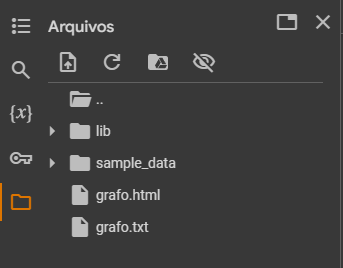

* As arestas mais grossas e com cores mais fortes têm peso maior.

* Clique na aresta para mostrar o seu peso.

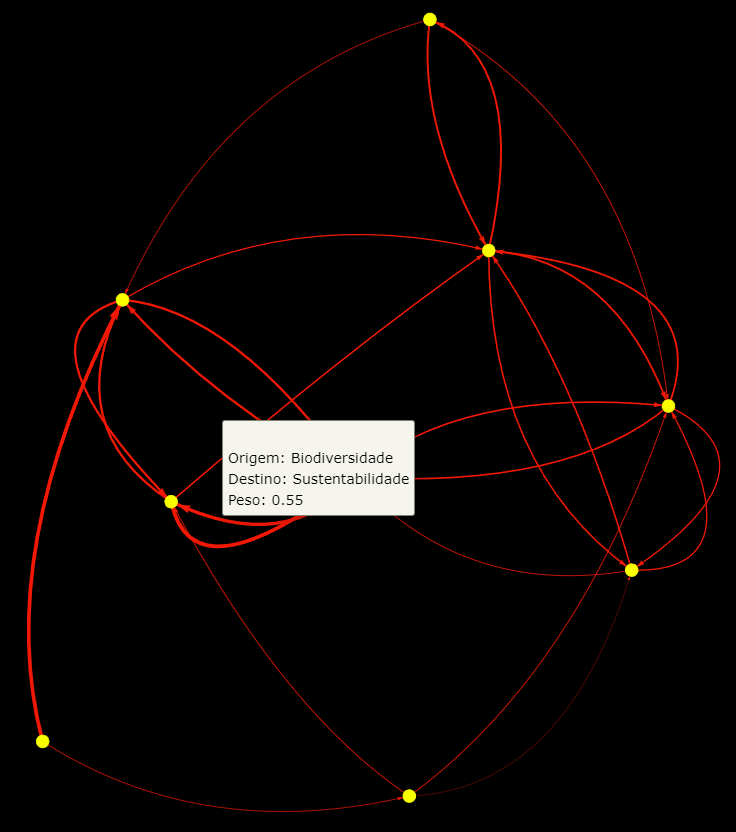

## 8. Exibir matriz (Feito)

In [247]:
g.showMin()


 n:  8 m: 23

 0.00  0.59  0.58  0.00  0.00  0.00  0.00  0.00 

 0.59  0.00  0.45  0.00  0.00  0.00  0.00  0.69 

 0.58  0.45  0.00  0.00  0.00  0.68  0.00  0.00 

 0.80  0.00  0.00  0.00  0.00  0.78  0.00  0.64 

 0.00  0.78  0.00  0.00  0.00  0.78  0.86  0.00 

 0.00  0.00  0.68  0.00  0.00  0.00  0.72  0.65 

 0.00  0.00  0.79  0.00  0.00  0.72  0.00  0.69 

 0.00  0.00  0.00  0.64  0.00  0.65  0.69  0.00 


fim da impressao do grafo.


## 9. Apresentar conexidade do grafo e o reduzido

# Menu

## Código

In [266]:
def menu():
    memoria = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0})
    fim = False

    while(fim == False):
        print(
    '''
    Menu:

        1) Ler dados do arquivo
        2) Gravar dados no arquivo grafo.txt
        3) Inserir vértice
        4) Inserir aresta
        5) Remover vértice
        6) Remover aresta
        7) Exibir grafo
        8) Exibir matriz
        9) Apresentar a conexidade do grafo e o reduzido
        10) Encerrar a aplicação
        11) Buscar um índice pela palavra
        12) Buscar uma palavra pelo índice
        13) Mostrar informações do vértice
    ''')
        choice = int(input())
        if choice == 1: # Cria grafo
            dados = leArquivoHTTP('https://raw.githubusercontent.com/Cehiim/TeoriaDosGrafos/refs/heads/main/Projeto/palavras.txt')
            #dados = leArquivo("palavras.txt")
            n_palavras = dados[0]
            vertices = dados[1]
            embedding(memoria, n_palavras, vertices)
            grafo = integraGrafo(memoria, n_palavras, vertices)
            print("Grafo criado com sucesso!")

        elif choice == 2: # Grava dados no arquivo .txt
            try:
                gravaDados(n_palavras, vertices)
                print("Os dados foram salvos no arquivo 'grafo.txt'.")
            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 3: # Insere vértice
            palavra = input("Palavra a ser inserida: ")
            try:
                insereVertice(grafo, n_palavras, vertices, palavra)
                n_palavras += 1
                print("Vértice inserido com sucesso!")

            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 4: # Insere aresta
            try:
                origem = int(input("Insira o índice de origem: "))
                destino = int(input("Insira o índice de destino: "))
                peso = float(input("Insira o peso: "))
                aresta = criaAresta(origem, destino)
                try:
                    insereAresta(grafo, n_palavras, vertices, aresta, peso)
                    print("Aresta inserida com sucesso!")

                except NameError:
                    print("[Erro: Grafo não criado]")

            except ValueError:
                print("[Erro: a entrada não é do tipo int]")

        elif choice == 5: # Remove vértice
            try:
                indice = int(input("Insira o índice do vértice: "))
                try:
                    removeVertice(grafo, n_palavras, vertices, indice)
                    n_palavras -= 1
                    print("Vértice removido com sucesso!")

                except NameError:
                    print("[Erro: Grafo não criado]")

            except ValueError:
                print("[Erro: a entrada não é do tipo int]")

        elif choice == 6: # Remove aresta
            try:
                origem = int(input("Insira o índice de origem: "))
                destino = int(input("Insira o índice de destino: "))
                aresta = criaAresta(origem, destino)
                try:
                    removeAresta(grafo, n_palavras, vertices, aresta)
                    print("Aresta removida com sucesso!")

                except NameError:
                    print("[Erro: Grafo não criado]")

            except ValueError:
                print("[Erro: a entrada não é do tipo int]")

        elif choice == 7: # Exibe grafo
            try:
                imprimeGrafo(n_palavras, vertices)
                print(f"Grafo direcionado com {g.n} vértices e {g.m} arestas\n")
                print("O grafo visual foi criado no arquivo 'grafo.html'.")
            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 8: # Exibe matriz
            try:
                grafo.showMin()
                print(("\nAperte ENTER para continuar "))
                ok = input()
            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 9: # Apresenta a conexidade do grafo e grafo reduzido
            try:
                print("oi")
            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 10: # Encerra
            fim = True
            print("Encerrando programa...")

        elif choice == 11: # Busca um índice pela palavra
            try:
                palavra = input("Palavra a ser consultada: ")
                indice = buscaIndice(n_palavras, vertices, palavra)
                if(indice == -1):
                    print("[Erro: palavra não encontrada]")
                else:
                    print(f"Índice de {palavra}: {indice}")
                    print(("\nAperte ENTER para continuar "))
                    ok = input()
            except NameError:
                print("[Erro: Grafo não criado]")

        elif choice == 12: # Busca um índice pela palavra
            try:
                indice = int(input("Índice a ser consultado: "))
                try:
                    palavra = buscaPalavra(n_palavras, vertices, indice)
                    if(indice == -1):
                        print("[Erro: palavra não encontrada]")
                    else:
                        print(f"Palavra do índice {indice}: {palavra}")
                        print(("\nAperte ENTER para continuar "))
                        ok = input()
                except NameError:
                  print("[Erro: Grafo não criado]")
            except ValueError:
                print("[Erro: a entrada não é do tipo int]")

        elif choice == 13: # Mostra informações do vértice
            try:
                indice = int(input("Índice do vértice: "))
                try:
                    mostraVertice(vertices, indice)
                    print(("\nAperte ENTER para continuar "))
                    ok = input()
                except NameError:
                  print("[Erro: Grafo não criado]")
            except ValueError:
                print("[Erro: a entrada não é do tipo int]")

        else:
            print("Opção inválida.")

        time.sleep(1)
        try:
            from IPython.display import clear_output

            clear_output(wait=True) # Limpa o terminal caso esteja no Google Colab

        except ImportError:
            if os.name == 'nt': # Limpa o terminal caso o OS seja Windows
                os.system('cls')
            else:
                os.system('clear') # Limpa o terminal caso o OS seja Linux ou MacOS

## Aplicação

In [267]:
menu()


    Menu:
        1) Ler dados do arquivo
        2) Gravar dados no arquivo grafo.txt
        3) Inserir vértice
        4) Inserir aresta
        5) Remover vértice
        6) Remover aresta
        7) Exibir grafo
        8) Exibir matriz
        9) Apresentar a conexidade do grafo e o reduzido
        10) Encerrar a aplicação
        11) Buscar um índice pela palavra
        12) Buscar uma palavra pelo índice
        13) Mostrar informações do vértice
    
10
Encerrando programa...
